In [214]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from fbg import *
from scipy.signal import find_peaks, peak_prominences

In [215]:
filepath = 'demos/spectra_files/psg_trn.txt'
data = psg_to_numpy(filepath, verbose=False)

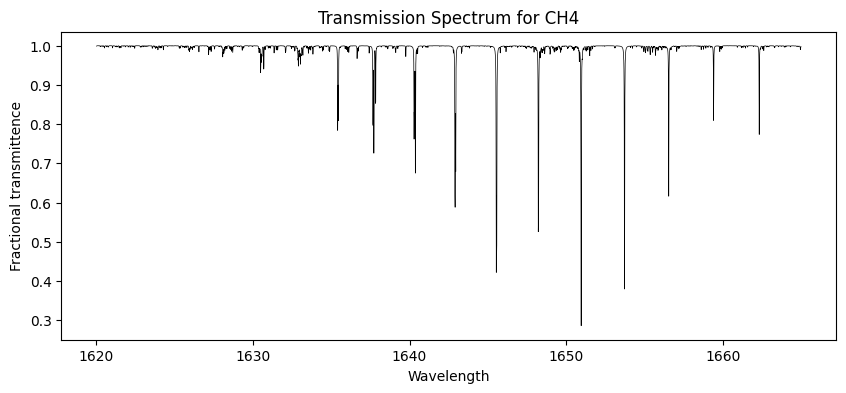

In [216]:
wavelength = data[:,0]*1e3 # converts units to nm
index =  np.where((wavelength>1620) & (wavelength<=1665))[0] # look at a small subset of the data

plt.figure(figsize=(10,4))
plt.plot(wavelength[index], data[index, 1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.show()

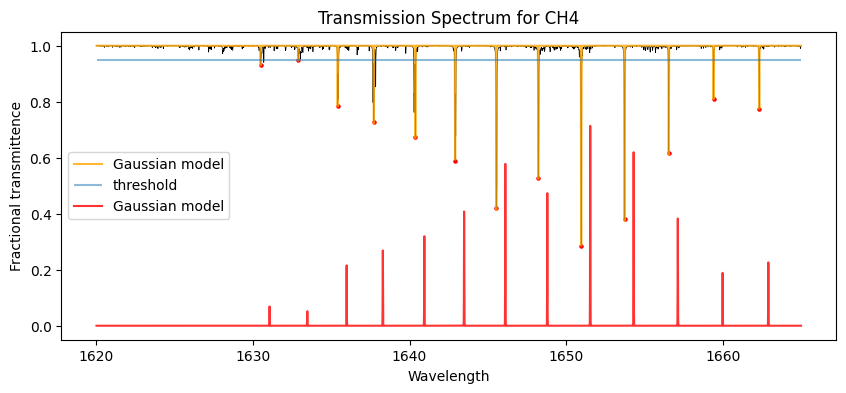

In [217]:
subset = data[index,:]
subset[:,0] = subset[:,0] * 1e3 # Convert wavelength to nm

# Plot original spectrum
plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5)

# Plot the simulated FBG
threshold_value = 0.95
peaks, properties = locate_peaks(subset[:, 1], threshold=threshold_value, distance=100) # distance=100 correspond to 1nm
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, 0, n=10000, sigma=1e-2, type='Gaussian')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.hlines(threshold_value, subset[:, 0].min(), subset[:, 0].max(), alpha=0.5, label='threshold')

# Apply strain to the FBG
strain = 500
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain, n=10000, sigma=1e-2, type='Gaussian')
plt.plot(wavelength_gauss, 1-trans_gauss, color='red', alpha=0.8, label='Gaussian model')

plt.xlabel('Wavelength'); plt.ylabel('Fractional transmittence'); 
plt.title('Transmission Spectrum for CH4')
plt.legend()
plt.show()


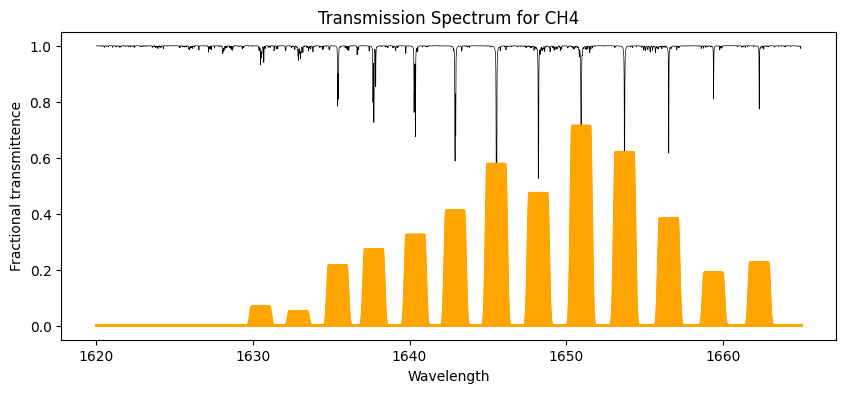

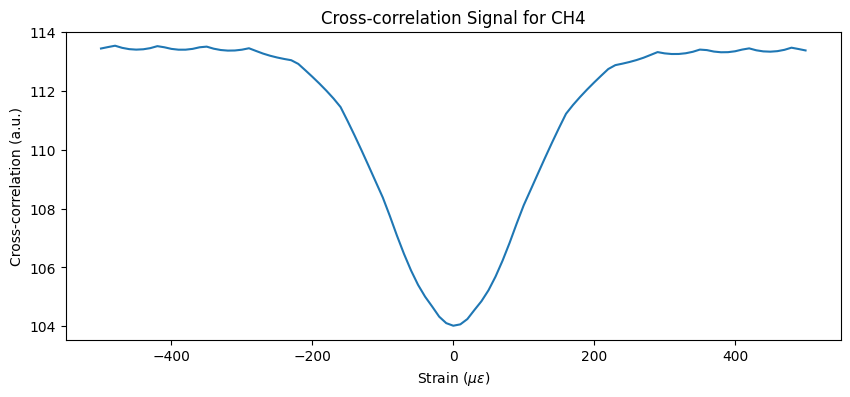

In [218]:
step = 101
strain = np.linspace(-500, 500, step)
cross_correlation = np.zeros(step)

plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
for i in range(len(strain)): 
    wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain[i], n=len(index), sigma=1e-1, type='Gaussian')
    cross_correlation[i] = np.sum(np.multiply((1-trans_gauss), subset[:,1]))
    plt.plot(wavelength_gauss, 1-trans_gauss, '-', color='orange', alpha=0.8, label='Gaussian model')
plt.xlabel('Wavelength'); plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(strain, cross_correlation)
plt.xlabel('Strain ($\mu\epsilon$)'); plt.ylabel('Cross-correlation (a.u.)')
plt.title('Cross-correlation Signal for CH4')
plt.show()

Define SNR as the ratio of signal peak to the RMS of noise.

"SCC" for spectral cross-correlation.

In [219]:

# mean_noise = np.mean(cross_correlation[0:100])
# print("The mean noise level is:",mean_noise)

# SCC_peak = np.abs(np.min(cross_correlation) - mean_noise)
# print("The signal peak level is:",SCC_peak) # signal peak

# std_noise = np.std(cross_correlation[0:100])
# print("The standard deviation of noise level is:",std_noise)

# SNR = 10*np.log(SCC_peak/std_noise)
# print("The SNR is:",SNR)

peaks_SCC, _ = find_peaks(-cross_correlation, distance=step)
prominences = peak_prominences(-cross_correlation, peaks_SCC)[0]
print("The signal peak prominence is:",prominences)

The signal peak prominence is: [9.44856727]


In [220]:
def generate_spectrum_height(data, peaks, height, strain, n=None, sigma=1e-5, type='Gaussian'):
    
    locs = data[peaks, 0]* (1+7e-7 * strain)
    heights = height * np.ones(len(peaks))

    if n is None:
        n = len(data)

    wavelengths = np.linspace(data[:, 0].min(), data[:, 0].max(), n)
    transmittence = np.zeros(n)

    if type == 'Gaussian':
        for i in range(len(peaks)):
            transmittence += gaussian(wavelengths, sigma=sigma, mu=locs[i], amp=heights[i])
    elif type == 'Lorentzian':
        for i in range(len(peaks)):
            transmittence += gaussian(wavelengths, sigma=sigma, mu=locs[i], amp=heights[i])
    else:
        print('Error: you need to specify a type of function to model the peak')

    transmittence *= heights.max()/transmittence.max()
    transmittence = 1 - transmittence

    return wavelengths, transmittence

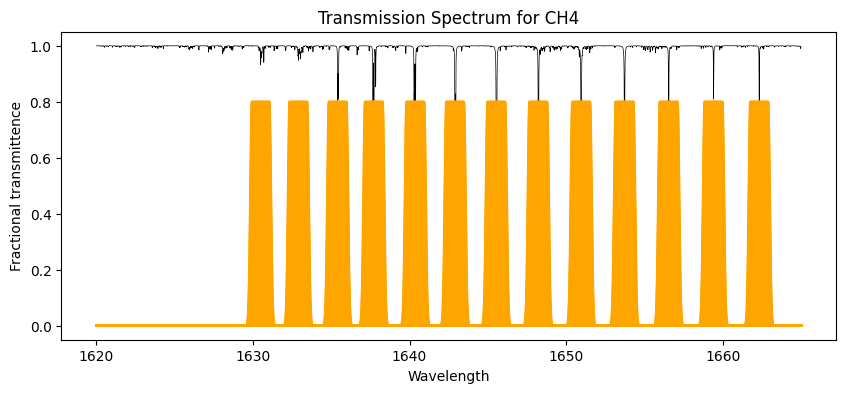

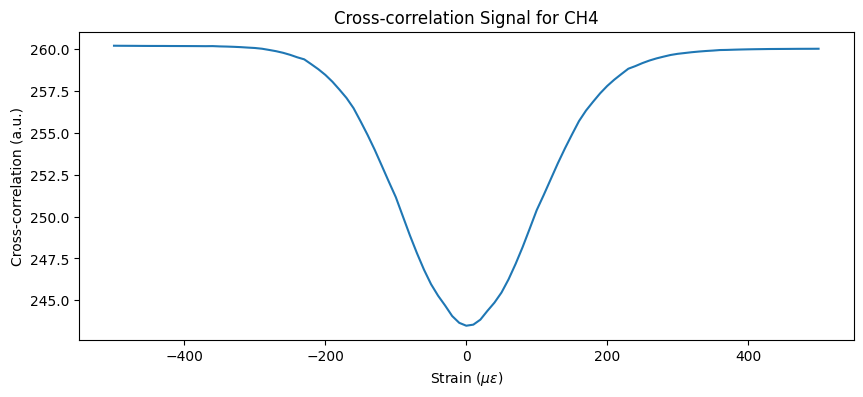

In [221]:
step = 101
strain = np.linspace(-500, 500, step)
cross_correlation = np.zeros(step)

plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
for i in range(len(strain)): 
    wavelength_gauss, trans_gauss = generate_spectrum_height(subset, peaks, 0.80, strain[i], n=len(index), sigma=1e-1, type='Gaussian')
    cross_correlation[i] = np.sum(np.multiply((1-trans_gauss), subset[:,1]))
    plt.plot(wavelength_gauss, 1-trans_gauss, '-', color='orange', alpha=0.8, label='Gaussian model')
plt.xlabel('Wavelength'); plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(strain, cross_correlation)
plt.xlabel('Strain ($\mu\epsilon$)'); plt.ylabel('Cross-correlation (a.u.)')
plt.title('Cross-correlation Signal for CH4')
plt.show()

# mean_noise = np.mean(cross_correlation[0:100])
# print("The mean noise level is:",mean_noise)

# SCC_peak = np.abs(np.min(cross_correlation) - mean_noise)
# print("The signal peak level is:",SCC_peak) # signal peak

# std_noise = np.std(cross_correlation[0:100])
# print("The standard deviation of noise level is:",std_noise)

# SNR = 10*np.log(SCC_peak/std_noise)
# print("The SNR is:",SNR)

In [222]:
peaks_SCC, _ = find_peaks(-cross_correlation, distance=step)
prominences = peak_prominences(-cross_correlation, peaks_SCC)[0]
print("The signal peak prominence is:",prominences)

The signal peak prominence is: [16.55365745]
